# Analysis of 10x Visium invasive ductal carcinoma slice

In this tutorial, we demonstrate SpaRCL on the analysis of 10x Visium invasive ductal carcinoma stained with fluorescent CD3 antibody slice including

* Spatial reconstruction
* Relational contrastive learning
* Spatial domain identification
* Spatial domain annotation
* Finding differentially expressed genes

The dataset is available at [10x genomics website](https://www.10xgenomics.com/resources/datasets) (Spatial Gene Expression >> Visium Spatial Gene Expression Fluorescent Demonstration (v1 Chemistry) >> Space Ranger 1.2.0 >> Invasive Ductal Carcinoma Stained With Fluorescent CD3 Antibody).

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

import SpaRCL as rcl

## Data loading and preprocessing

We load the dataset and find top 2000 highly variable genes.

In [2]:
adata = sc.read_visium('./data/Invasive Ductal Carcinoma Stained With Fluorescent CD3 Antibody/')
adata.var_names_make_unique()
adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 4727 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [3]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='seurat_v3')

## Spatial reconstruction

We perform spatial reconstruction to aggregate expression from spatial neighbors.

In [4]:
rcl.spatial_reconstruction(adata)

## Relational contrastive learning

We perform relational contrastive learning on the reconstructed data.

In [5]:
rcl.run_RCL(adata)

 60%|██████████████████████████████                    | 601/1000 [04:34<03:02,  2.19it/s, err=9.86375e-06, converged!]


## Spatial domain identification

We identify spatial domains using the relation matrix.

In [6]:
sc.tl.leiden(adata, resolution=1.5, neighbors_key='relation')

... storing 'feature_types' as categorical
... storing 'genome' as categorical


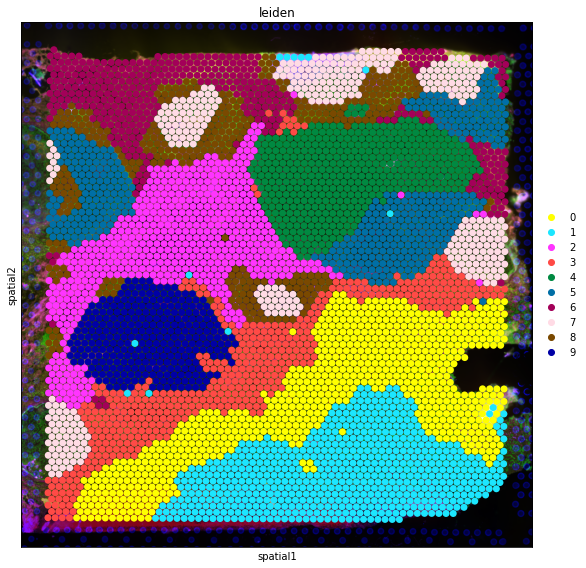

In [7]:
fig, axs = plt.subplots(figsize=(8, 8))

sc.pl.spatial(
    adata,
    img_key='hires',
    color='leiden',
    size=1.5,
    palette=sc.pl.palettes.default_102,
    legend_loc='right margin',
    show=False,
    ax=axs,
)

plt.tight_layout()

## Spatial domain annotation

We annotate the spatial domains based on the pathologist annotation from [Zhao, E. et al.](https://www.nature.com/articles/s41587-021-00935-2)

In [8]:
map_dict = {
    '0': 'Invasive',
    '1': 'Invasive',
    '2': 'Non-tumor',
    '3': 'Non-tumor',
    '4': 'Invasive',
    '5': 'Benign',
    '6': 'Non-tumor',
    '7': 'In situ',
    '8': 'Non-tumor',
    '9': 'Invasive',
}

In [9]:
adata.obs['annotation'] = pd.Categorical(
    adata.obs['leiden'].map(map_dict),
    categories=['Invasive', 'In situ', 'Non-tumor', 'Benign']
)

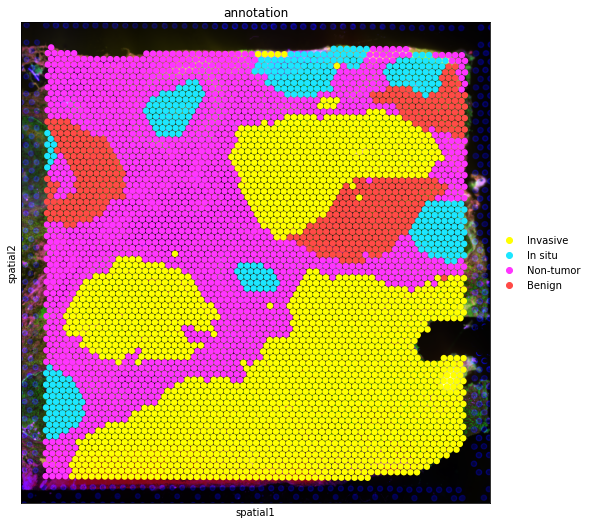

In [10]:
fig, axs = plt.subplots(figsize=(8, 8))

sc.pl.spatial(
    adata,
    img_key='hires',
    color='annotation',
    size=1.5,
    palette=sc.pl.palettes.default_102,
    legend_loc='right margin',
    show=False,
    ax=axs,
)

plt.tight_layout()

## Finding differentially expressed genes

We find the differentially expressed (DE) genes across identified domains and show their expression patterns in spatial coordinates.

In [11]:
sc.tl.rank_genes_groups(adata, groupby='leiden', use_raw=False, layer='counts', method='t-test')

In [12]:
de_genes = pd.DataFrame(adata.uns['rank_genes_groups']['names']).iloc[:10,:]
de_genes

,0,1,2,3,4,5,6,7,8,9
0,MUC1,CXCL14,MT-CO2,CD74,SLC39A6,SCGB1D2,MALAT1,MGP,IGKC,IFI6
1,CXCL14,GALNT6,MT-ND1,APOE,ZNF703,SCGB2A2,CCDC80,H2AFJ,IGHG3,RPL30
2,TCEAL4,SPP1,MT-ND2,C1QB,CFB,CSTA,ANKRD12,SNHG25,IGHG4,RPL19
3,CCND1,MUC1,IGHG3,C1QA,BAMBI,S100G,IGKC,TFF3,IGLC2,NME2
4,TTLL12,COL1A2,IGKC,TIMP1,MUC5B,ADIRF,ATRX,ERLIN2,C3,HLA-B
5,KRT8,DNAJC1,MT-ND4,HLA-DRA,TMEM150C,MGP,SAMHD1,COPS9,IGHG1,NQO1
6,GALNT6,TCEAL4,IGLC2,FTL,RPS18,H2AFJ,FYB1,ZNF703,IGHA1,KRT19
7,KRT18,ATP9A,MT-ATP6,BGN,TNFSF10,HEBP1,HSP90B1,SLC9A3R1,C1QA,LGALS3BP
8,DEGS2,VEGFA,MT-ND5,HLA-DPB1,IGFBP5,FAM234B,CALD1,TOB1,IGLC1,BAMBI
9,AGR2,PRRC2C,MT-CO1,CTSD,XBP1,HLA-A,BOD1L1,ACTG1,JCHAIN,HLA-A


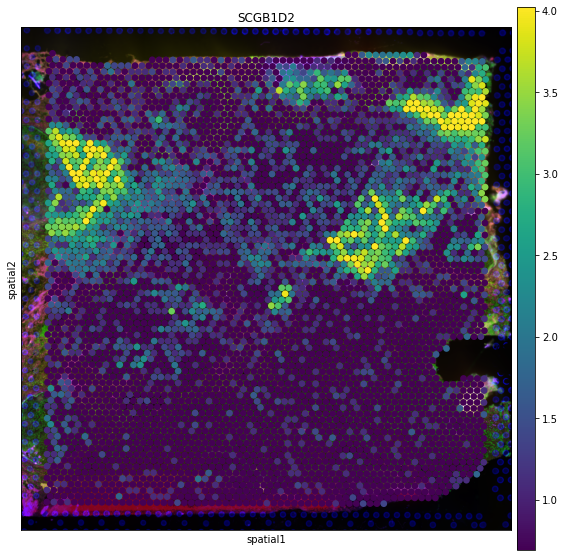

In [13]:
fig, axs = plt.subplots(figsize=(8, 8))

sc.pl.spatial(
    adata,
    img_key='hires',
    color=de_genes.iloc[0,5],
    layer='log1p',
    size=1.5,
    palette=sc.pl.palettes.default_102,
    legend_loc='right margin',
    vmin='p50',
    vmax='p99',
    show=False,
    ax=axs,
)

plt.tight_layout()

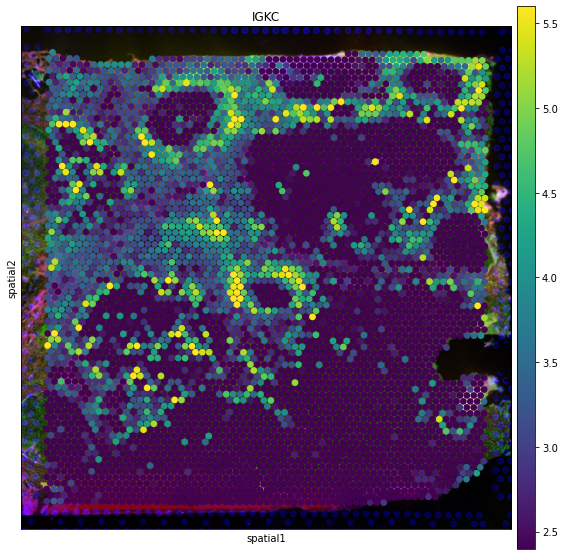

In [14]:
fig, axs = plt.subplots(figsize=(8, 8))

sc.pl.spatial(
    adata,
    img_key='hires',
    color=de_genes.iloc[0,8],
    layer='log1p',
    size=1.5,
    palette=sc.pl.palettes.default_102,
    legend_loc='right margin',
    vmin='p50',
    vmax='p99',
    show=False,
    ax=axs,
)

plt.tight_layout()